# Cell Type Annotation and Harmonization
This notebook maps external cell type annotations to the ArchR project and harmonizes labels across datasets for integrated analysis. 

**Input:** QC-filtered ArchR project from preprocessing pipeline

**Output:** Annotated project with unified cell type labels across mPB and BM datasets

## 1. Setup

In [1]:
library(ArchR)
library(hdf5r)
library(ggplot2)
library(dplyr)
library(knitr)
library(scales)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
# Load project
proj <- loadArchRProject("ArchR_Collab_vs_Pub_Final")

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

## 2. Read Supplementary Cell Type Annotations

In [3]:
# Read collaborator annotations from .h5ad 
adata <- H5File$new("../../../data/data_raw/collaborators/scrna_adata_annot_2.h5ad", mode = "r")
collab_bcs <- adata[["obs/_index"]][]
cats        <- adata[["obs/annotation/categories"]][]
codes       <- adata[["obs/annotation/codes"]][]
adata$close_all()
collabTypes <- cats[codes + 1]
names(collabTypes) <- collab_bcs

# Read Granja CSV
meta_df     <- read.csv("/work/project/ladcol_013/bt-atac/data/data_raw/granja/CD34_cells_metadata.csv",
                        stringsAsFactors = FALSE)
granjaTypes <- setNames(meta_df$cell_type, meta_df$barcode)

## 3. Match Barcodes

In [4]:
# Grab all cell‐names and sample assignments
allCells   <- getCellNames(proj)
allSamples <- getCellColData(proj)$Sample

# Extract short barcodes
shortBC <- sub("^.*#", "", allCells)

## 4. Add Cell Type Annotations

In [5]:
# Build one big NA‐filled annotation vector
annotVec <- setNames(rep(NA_character_, length(allCells)), allCells)

# Fill in collab
isCollab    <- allSamples %in% c("collab_0","collab_1")
collabCells <- allCells[isCollab]
collabBC    <- shortBC[isCollab]
annotVec[collabCells] <- collabTypes[collabBC]

# Fill in granja
granjaSamples <- paste0("granja_D", 7:9, "T1")
isGranja      <- allSamples %in% granjaSamples
granjaCells   <- allCells[isGranja]
granjaBC      <- shortBC[isGranja]
annotVec[granjaCells] <- granjaTypes[granjaBC]

In [6]:
# Store in proj
proj <- addCellColData(
  ArchRProj = proj,
  data      = annotVec,
  cells     = allCells,
  name      = "CellType",
  force     = TRUE
)

In [7]:
# Verify
ct   <- getCellColData(proj)$CellType
samp <- getCellColData(proj)$Sample
table(!is.na(ct), samp)

       samp
        collab_0 collab_1 granja_D7T1 granja_D8T1 granja_D9T1
  FALSE      263      294         473         213         187
  TRUE      3425     3064        2731        3277        3685

## 5. Harmonize Cell Type Labels

In [8]:
# Get raw cell types
raw_ct <- getCellColData(proj)$CellType
cell_ids <- rownames(getCellColData(proj))
names(raw_ct) <- cell_ids

# Define mapping from original to unified
label_map <- c(
  `01_HSC`         = "HSC",
  `HSC/MPP`        = "HSC",
  `05_CMP.LMPP`    = "LMPP",
  `06_CLP.1`       = "CLP",  
  `15_CLP.2`       = "CLP",  
  `MLP`            = "CLP",
  `07_GMP`         = "GMP",  
  `08_GMP.Neut`    = "GMP",  
  `GMP`            = "GMP",  
  `granu/macroP`   = "GMP",
  `02_Early.Eryth` = "Erythroid",
  `04_Early.Baso`  = "Basophil",
  `EP`             = "Erythroid",
  `MEP`            = "MEP",
  `MKP`            = "MKP",
  `MDP`            = "MDP",
  `09_pDC`         = "DC",
  `10_cDC`         = "DC",
  `16_Pre.B`       = "B_lineage",
  `17_B`           = "B_lineage",    
  `earlyB`         = "B_lineage",
  `21_CD4.N2`      = "T_lineage",
  `ETP`            = "T_lineage",
  `12_CD14.Mono.2` = "Monocyte"
)

# Map to unified, keeping cell IDs as names
unified_vec <- setNames(label_map[raw_ct], cell_ids)

# Check the distribution
table(unified_vec, useNA = "ifany")

# Add to project
proj <- addCellColData(
  ArchRProj = proj,
  data      = unified_vec,
  cells     = cell_ids,
  name      = "CellType_Unified",
  force     = TRUE
)

# Verify
cat("Added CellType_Unified with", length(unique(na.omit(unified_vec))), "unique cell types\n")


unified_vec
B_lineage  Basophil       CLP        DC Erythroid       GMP       HSC      LMPP 
       63       310      1840       397      1704      2843      5063      2340 
      MDP       MEP       MKP  Monocyte T_lineage      <NA> 
      110      1028       343        16       125      1430 

Added CellType_Unified with 13 unique cell types


## 6. Cell Type Distribution Plot

Saved plot to: Unified_CellType_By_Dataset.svg

Saved plot to: Unified_CellType_By_Dataset_Filtered.svg



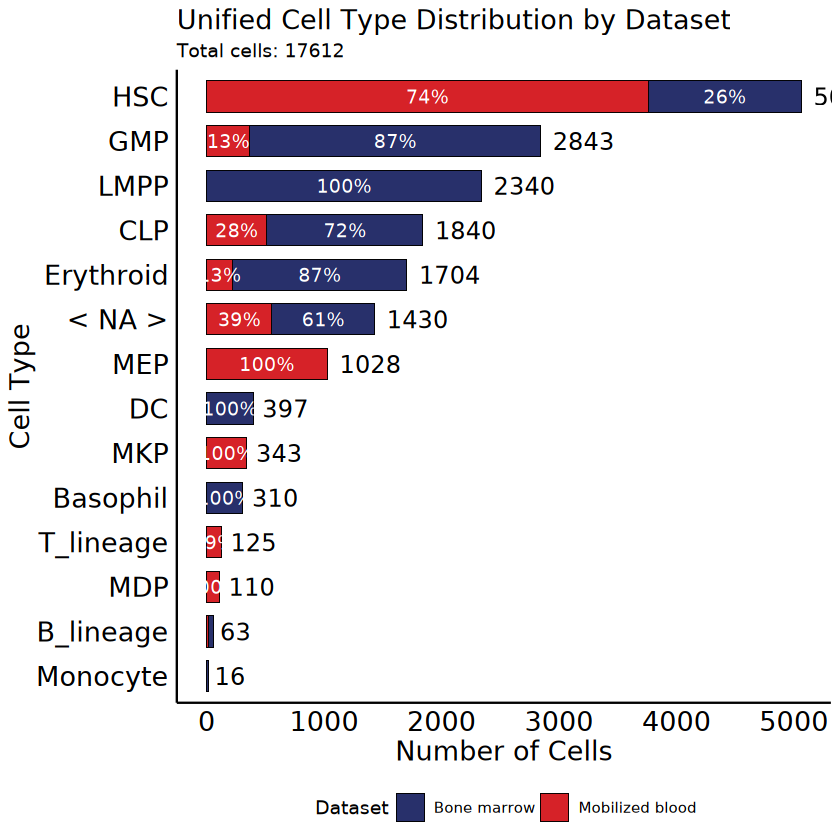

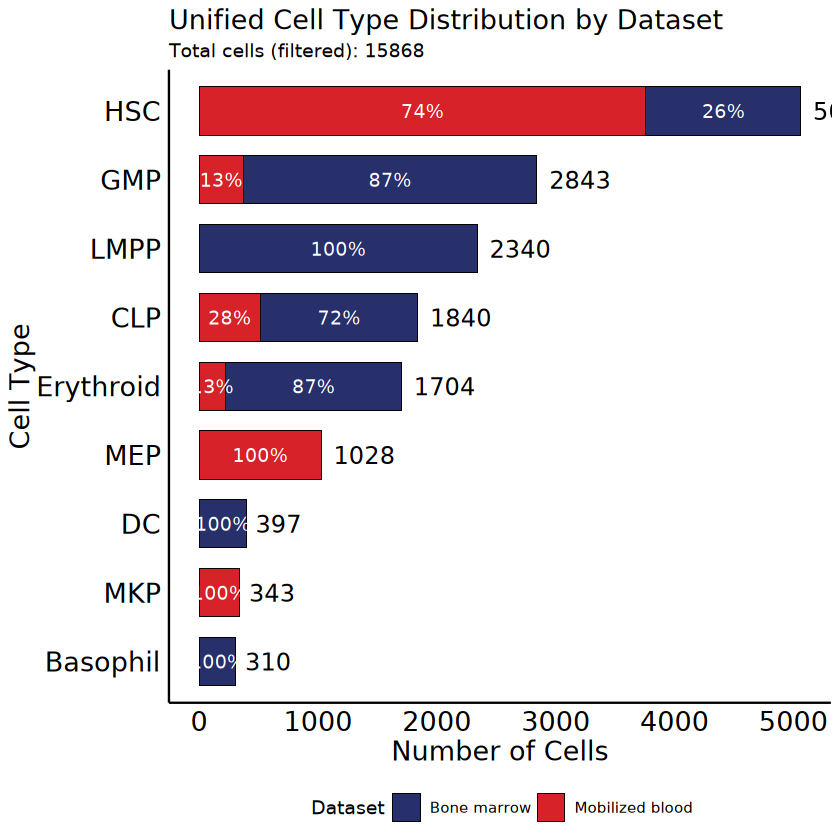

In [9]:
plot_celltype_distribution <- function(proj, 
                                        filter_na = FALSE, 
                                        min_cluster_size = 0,
                                        output_file = NULL,
                                        width = 20,
                                        height = 9) {
  

  # --- 1. Get data ONCE from project ---
  cell_data <- getCellColData(proj)
  unified_ct <- cell_data$CellType_Unified
  sample <- cell_data$Sample
  

  # --- 2. Prepare dataset labels ---
  dataset <- ifelse(grepl("^collab_", sample), "Mobilized blood", "Bone marrow")
  
  
  # --- 3. Build summary dataframe ---
  split_df <- data.frame(
    CellType = as.character(unified_ct),
    Dataset = dataset
  ) %>%
    mutate(CellType = ifelse(is.na(CellType), "< NA >", CellType)) %>%
    group_by(CellType, Dataset) %>%
    summarise(Count = n(), .groups = "drop_last") %>%
    mutate(Total_Cluster_Size = sum(Count))
  
  
  # --- 4. Apply filters if requested ---
  if (filter_na) {
    split_df <- split_df %>% filter(CellType != "< NA >")
  }
  
  if (min_cluster_size > 0) {
    split_df <- split_df %>% filter(Total_Cluster_Size >= min_cluster_size)
  }
  
  
  # --- 5. Calculate percentages and reorder ---
  split_df <- split_df %>%
    mutate(Percentage = Count / Total_Cluster_Size) %>%
    ungroup() %>%
    mutate(CellType = reorder(CellType, Total_Cluster_Size))
  
  
  # --- 6. Create totals dataframe for labels ---
  totals_df <- split_df %>% 
    select(CellType, Total_Cluster_Size) %>% 
    distinct()
  
  
  # --- 7. Build subtitle based on filtering ---
  subtitle_text <- if (filter_na || min_cluster_size > 0) {
    paste0("Total cells (filtered): ", sum(split_df$Count))
  } else {
    paste0("Total cells: ", sum(split_df$Count))
  }
  
  
  # --- 8. Create the plot ---
  p <- ggplot(split_df, aes(x = CellType, y = Count, fill = Dataset)) +
    geom_bar(stat = "identity", position = "stack", width = 0.7, 
             color = "black", linewidth = 0.2) +
    coord_flip() +
    
    # Inner text: Percentages
    geom_text(aes(label = ifelse(Count > 50, 
                                 percent(Percentage, accuracy = 1), 
                                 "")), 
              position = position_stack(vjust = 0.5), 
              size = 4,
              color = "white", 
              fontface = "bold") +
    
    # Outer text: Totals
    geom_text(data = totals_df,
              aes(x = CellType, y = Total_Cluster_Size, label = Total_Cluster_Size),
              inherit.aes = FALSE,
              hjust = -0.2,
              size = 5, 
              fontface = "italic") +
    
    scale_fill_manual(values = c("Bone marrow" = "#28306B", 
                                 "Mobilized blood" = "#D62228")) +
    theme_minimal() +
    labs(title = "Unified Cell Type Distribution by Dataset",
         subtitle = subtitle_text,
         y = "Number of Cells",
         x = "Cell Type") +
    
    theme(plot.title = element_text(size = 16, face = "bold"),
          axis.title = element_text(size = 16, face = "bold"),
          axis.text.y = element_text(size = 16, color = "black"),
          axis.text.x = element_text(size = 16, color = "black"),
          panel.grid = element_blank(),
          axis.line = element_line(color = "black"),
          legend.position = "bottom")
  
  
  # --- 9. Save if output file specified ---
  if (!is.null(output_file)) {
    ggsave(output_file, p, width = width, height = height, device = "pdf")
    message("Saved plot to: ", output_file)
  }
  
  return(p)
}


# =============================================================================
# Plotting
# =============================================================================

# Plot 1: All cell types
p_all <- plot_celltype_distribution(
  proj, 
  output_file = "Unified_CellType_By_Dataset.pdf"
)
print(p_all)


# Plot 2: Filtered (no NA, min 250 cells)
p_filtered <- plot_celltype_distribution(
  proj,
  filter_na = TRUE,
  min_cluster_size = 250,
  output_file = "Unified_CellType_By_Dataset_Filtered.pdf"
)
print(p_filtered)


## 7. Export Harmonization Table

In [10]:
# Get cell metadata
raw_ct <- getCellColData(proj)$CellType
unified_ct <- getCellColData(proj)$CellType_Unified
tissue <- getCellColData(proj)$Tissue

# Create mapping table with tissue
mapping_table <- data.frame(
  Harmonized_Cell_Type = as.character(unified_ct),
  Original_Cell_Type = as.character(raw_ct),
  Tissue = as.character(tissue)
) %>%
  filter(!is.na(Harmonized_Cell_Type)) %>%
  mutate(Tissue = case_when(
    Tissue == "MobilizedBlood" ~ "mPB",
    Tissue == "BoneMarrow" ~ "BM",
    TRUE ~ Tissue
  )) %>%
  group_by(Harmonized_Cell_Type, Original_Cell_Type, Tissue) %>%
  summarise(Cell_Count = n(), .groups = "drop") %>%
  arrange(Harmonized_Cell_Type, Tissue, desc(Cell_Count))

# View the table
kable(mapping_table, caption = "Cell Type Harmonization")

# Export to CSV
write.csv(mapping_table, "celltype_mapping.csv", row.names = FALSE)



Table: Cell Type Harmonization

|Harmonized_Cell_Type |Original_Cell_Type |Tissue | Cell_Count|
|:--------------------|:------------------|:------|----------:|
|B_lineage            |16_Pre.B           |BM     |         38|
|B_lineage            |17_B               |BM     |          6|
|B_lineage            |earlyB             |mPB    |         19|
|Basophil             |04_Early.Baso      |BM     |        310|
|CLP                  |06_CLP.1           |BM     |        688|
|CLP                  |15_CLP.2           |BM     |        638|
|CLP                  |MLP                |mPB    |        514|
|DC                   |09_pDC             |BM     |        389|
|DC                   |10_cDC             |BM     |          8|
|Erythroid            |02_Early.Eryth     |BM     |       1483|
|Erythroid            |EP                 |mPB    |        221|
|GMP                  |07_GMP             |BM     |       1309|
|GMP                  |08_GMP.Neut        |BM     |       1164|
|GMP  

## 8. Save Annotated Project

In [11]:
getwd()

[1] "/work/project/ladcol_013/bt-atac/notebooks/1_processing/test"

In [12]:
saveArchRProject(proj, outputDirectory = "ArchR_Collab_vs_Pub_Annotated", load = FALSE)

Copying ArchRProject to new outputDirectory : /work/project/ladcol_013/bt-atac/notebooks/1_processing/test/ArchR_Collab_vs_Pub_Annotated

Copying Arrow Files...

Copying Arrow Files (1 of 5)

Copying Arrow Files (2 of 5)

Copying Arrow Files (3 of 5)

Copying Arrow Files (4 of 5)

Copying Arrow Files (5 of 5)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 9): collab_0

Copying Other Files (2 of 9): collab_1

Copying Other Files (3 of 9): granja_D7T1

Copying Other Files (4 of 9): granja_D8T1

Copying Other Files (5 of 9): granja_D9T1

Copying Other Files (6 of 9): GroupCoverages

Copying Other Files (7 of 9): IterLSI1

Copying Other Files (8 of 9): PeakCalls

Copying Other Files (9 of 9): Plots

Saving ArchRProject...

